# LSTM Implementation (85% Accuracy)

In [1]:
import numpy as np 
import pandas as pd 
import re

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

### Changing device to GPU

In [4]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Loading Dataset

In [5]:
sample_size = 90000
dataset = pd.read_csv("../data/reviews_dataset.csv")
dataset = dataset.sample(frac=1)
x_train, x_test, y_train, y_test = train_test_split(dataset["text"].values[:sample_size], dataset["labels"].values[:sample_size], test_size=0.3, random_state=42)

print("Train dataset size -> Sample {}, Labels {}".format(x_train.shape, y_train.shape))
print("Test dataset size -> Sample {}, Labels {}".format(x_test.shape, y_test.shape))

Train dataset size -> Sample (63000,), Labels (63000,)
Test dataset size -> Sample (27000,), Labels (27000,)


In [6]:
len(np.where(y_train == 1)[0])

31528

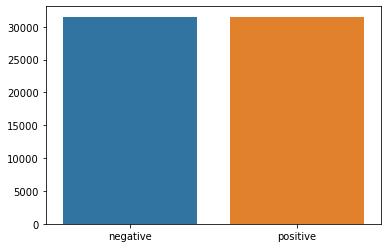

In [7]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

### Tokenizing

In [8]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenizer(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    # encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    # encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(y_train),np.array(final_list_test), np.array(y_val),onehot_dict

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaishanth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
x_train_tokenized, y_train, x_test_tokenized, y_test, vocab = tokenizer(x_train, y_train, x_test, y_test)

/home/vaishanth/anaconda3/envs/env_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
len(np.where(y_train == 1)[0])

31528

In [12]:
x_train_tokenized

array([list([89, 834, 63, 90, 449, 345, 154]),
       list([940, 63, 353, 7, 940, 84, 7, 198, 795, 940, 473, 33, 319, 940, 6, 57, 1]),
       list([625, 25, 392, 27, 139, 245, 69, 281, 59, 19, 298, 69, 434]),
       ...,
       list([3, 347, 639, 320, 347, 198, 100, 83, 644, 133, 86, 86, 215, 540, 723, 15, 120, 859, 58, 687, 15, 201, 748, 263, 8]),
       list([1, 501, 541, 169, 1, 244, 5, 58, 905, 63, 121, 501, 63, 34, 910, 600, 169, 24, 27, 8, 556, 15, 111, 662, 143, 414, 920, 796, 98, 65, 796, 63, 5, 593, 133, 563, 600, 640, 678, 22, 1, 21, 182, 414, 66, 307, 83, 8, 201]),
       list([488, 488, 87, 1, 5, 770])], dtype=object)

In [13]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

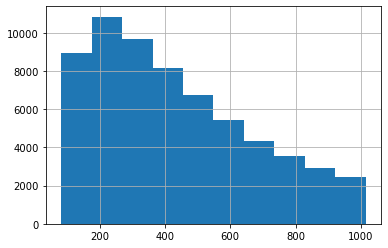

count    63000.000000
mean       432.688524
std        237.880376
min         82.000000
25%        233.000000
50%        384.000000
75%        596.000000
max       1015.000000
dtype: float64

In [14]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

In [15]:
def padder(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [16]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padder(x_train_tokenized,500)
x_test_pad = padder(x_test_tokenized,500)

In [17]:
x_train_pad

array([[  0,   0,   0, ..., 449, 345, 154],
       [  0,   0,   0, ...,   6,  57,   1],
       [  0,   0,   0, ..., 298,  69, 434],
       ...,
       [  0,   0,   0, ..., 748, 263,   8],
       [  0,   0,   0, ...,  83,   8, 201],
       [  0,   0,   0, ...,   1,   5, 770]])

### Batching and loading as tensor

In [18]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [19]:
# obtain one batch of training data
data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 157,  33, 117],
        [  0,   0,   0,  ...,  29, 141,  59],
        [  0,   0,   0,  ...,  47,   8,  96],
        ...,
        [  0,   0,   0,  ..., 385,  23,   5],
        [  0,   0,   0,  ..., 582, 263, 681],
        [  0,   0,   0,  ..., 333,   1,   5]])
Sample input: 
 tensor([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 1])


We need to add an embedding layer because there are less words in our vocabulary. It is massively inefficient to one-hot encode that many classes. So, instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table. You could train an embedding layer using Word2Vec, then load it here. But, it's fine to just make a new layer, using it for only dimensionality reduction, and let the network learn the weights.

## Model

In [20]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [21]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
# vocab_size = 1000
embedding_dim = 64
output_dim = 1
hidden_dim = 256

model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Training

In [22]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [23]:
clip = 5
epochs = 5 
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.4393040349677442 val_loss : 0.3567219441411672
train_accuracy : 79.51904761904763 val_accuracy : 84.1888888888889
Validation loss decreased (inf --> 0.356722).  Saving model ...
Epoch 2
train_loss : 0.32896496742845527 val_loss : 0.3350374323074464
train_accuracy : 85.75396825396825 val_accuracy : 84.92222222222222
Validation loss decreased (0.356722 --> 0.335037).  Saving model ...
Epoch 3
train_loss : 0.29787795897277575 val_loss : 0.31610886507012226
train_accuracy : 87.25238095238095 val_accuracy : 86.34444444444445
Validation loss decreased (0.335037 --> 0.316109).  Saving model ...
Epoch 4
train_loss : 0.2672239743557478 val_loss : 0.32224982745117614
train_accuracy : 88.73809523809524 val_accuracy : 86.11851851851851
Epoch 5
train_loss : 0.22081869281237088 val_loss : 0.3388840281577022
train_accuracy : 90.98888888888888 val_accuracy : 85.34444444444445


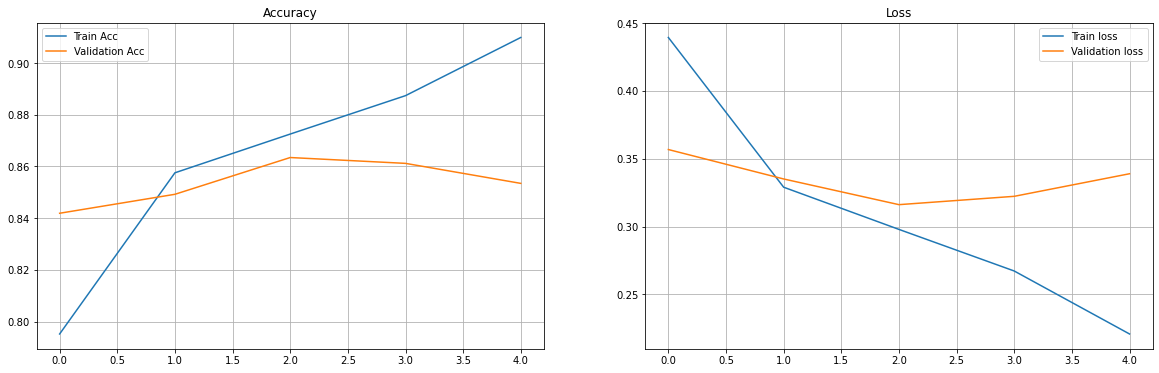

In [29]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Predictions


In [30]:
def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                        if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padder(word_seq,500))
    inputs = pad.to(device)
    batch_size = 1
    h = model.init_hidden(batch_size)
    h = tuple([each.data for each in h])
    output, h = model(inputs, h)
    return(output.item())

In [31]:
x_train[30]

'great book for the confused: this is an awesome book for those who are troubled or confused about the justice, mercy, love and "hate" of god. it also explains passages such as god "desiring all men to be saved" or how can god hate others under reprobation. this is, ironically, one of the best defenses of the reformed or calvinist faith. sproul is such and outstanding teacher, and he explains these difficult concepts using the historical church as well as a careful examination of scripture to back his claims. this book sinks into your pysche, and after reading it, you will think of the contents well after this book goes paperback. does sproul speak infallibly ex cathedra on matters of faith? sometimes i am convinced he does. easy to understand, this book is a winner for layman, students, and clergy.'

In [51]:
rand_id = np.random.randint(x_test.shape[0])
print(x_test[rand_id])
print('='*70)
print(f'Actual sentiment is  : {y_test[rand_id]}')
print('='*70)
pro = predict_text(x_test[rand_id])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

you can find it any where: the information in this book can be found on any google search. i like the over all concept of getting a solar oven to reduce energy use or emergency situations where the grid is down. the book is alright but save the money and google or you tube how to make a solar oven. the recipes looked good, but any slow cooker recipe will work.
Actual sentiment is  : 0
Predicted sentiment is negative with a probability of 0.9987154906848446


In [28]:
np.where(y_test == 0)

(array([    1,     3,     5, ..., 26991, 26995, 26998]),)